In [3]:
# === PASO 2: Preprocesamiento (Filtrado) ===

raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)

print("Datos filtrados y listos en la variable 'raw_filtered'.")

Datos filtrados y listos en la variable 'raw_filtered'.


In [13]:
# === PASO 3: Entrenamiento y Diagnóstico de ICA (Sujeto Sano) ===
from mne.preprocessing import ICA

print("Entrenando ICA para el sujeto sano (puede tardar unos minutos)...")

# Para estos datos de alta calidad, podemos usar más componentes para una mejor separación
ica = ICA(n_components=30, max_iter='auto', random_state=97) 
ica.fit(raw_filtered, verbose=False)

print("\n--- ¡ACCIÓN REQUERIDA! ---")
print("Inspeccione el siguiente gráfico y anote los números de los componentes que parezcan artefactos.")
ica.plot_sources(raw_filtered)

Entrenando ICA para el sujeto sano (puede tardar unos minutos)...

--- ¡ACCIÓN REQUERIDA! ---
Inspeccione el siguiente gráfico y anote los números de los componentes que parezcan artefactos.
Creating RawArray with float64 data, n_channels=30, n_times=166800
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


Excluyendo componentes [0, 1, 2] y aplicando la limpieza...
Datos limpios y listos.

--- Iniciando Análisis de las 3 Métricas para el Sujeto Sano ---
Calculando Entropía...
Calculando Conectividad, Homología y Curvatura...
Análisis completado. Generando panel de resultados...


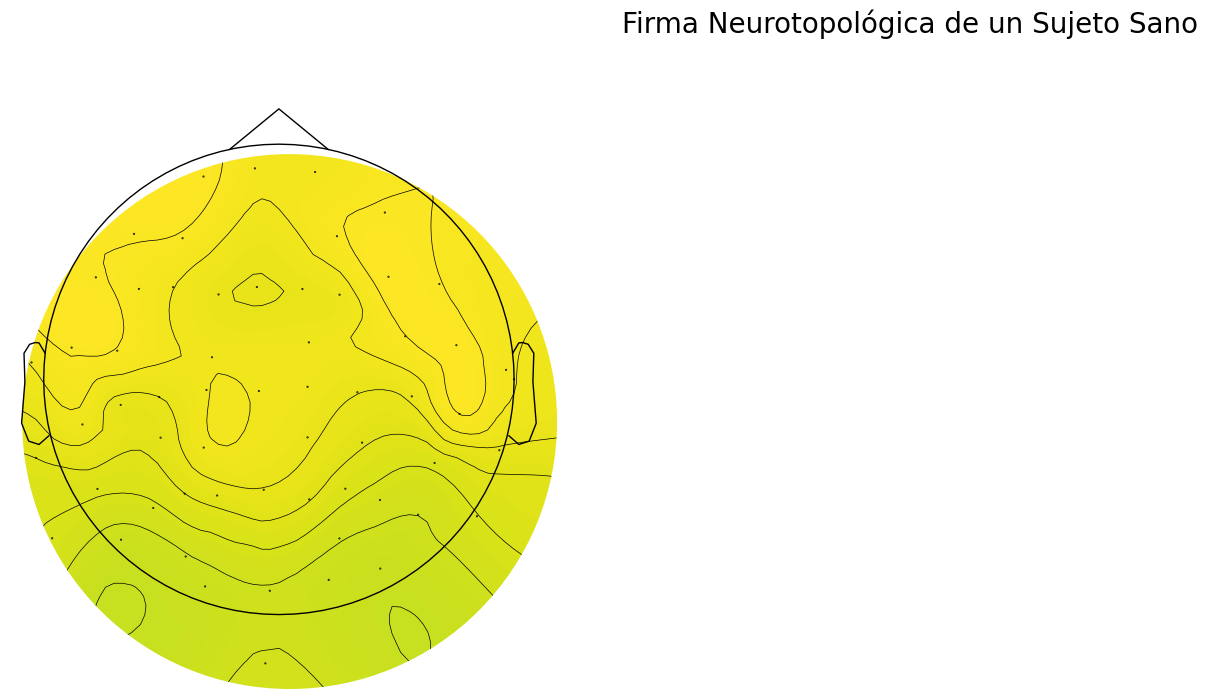

C:\Users\artur\AppData\Local\Temp\ipykernel_31832\1046335932.py:69: UserWarning: Adding colorbar to a different Figure <Figure size 2400x800 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar1 = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)


<Figure size 640x480 with 0 Axes>

C:\Users\artur\AppData\Local\Temp\ipykernel_31832\1046335932.py:83: UserWarning: Adding colorbar to a different Figure <Figure size 2400x800 with 5 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar3 = plt.colorbar(edges, ax=ax3, fraction=0.046, pad=0.04)


<Figure size 640x480 with 0 Axes>

In [6]:
# === PASO 4: Limpieza (basada en su decisión) y Análisis Final del Sujeto Sano ===
import numpy as np
import antropy as ant
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import wasserstein_distance
import ripser
import persim
import mne # Re-importamos por si acaso

# --- ¡SU DECISIÓN CIENTÍFICA AQUÍ! ---
# Basado en el gráfico anterior, definimos los componentes a excluir
components_a_excluir = [0, 1, 2] # Su diagnóstico

# --- Limpieza de Datos ---
print(f"Excluyendo componentes {components_a_excluir} y aplicando la limpieza...")
try:
    ica.exclude = components_a_excluir
    raw_cleaned = ica.apply(raw.copy(), verbose=False) # Aplicamos sobre la copia de 'raw' que no está filtrada aún para el análisis
    print("Datos limpios y listos.")
except Exception as e:
    print(f"ERROR en la limpieza: {e}")
    raise

# --- ANÁLISIS DE PSICOMETRÍA NEUROTOPOLÓGICA ---
print("\n--- Iniciando Análisis de las 3 Métricas para el Sujeto Sano ---")

# A. CÁLCULO DE ENTROPÍA
print("Calculando Entropía...")
# Filtramos los datos limpios para el cálculo de la entropía
raw_cleaned_filtered = raw_cleaned.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)
datos_eeg_entropia = raw_cleaned_filtered.get_data(units='V')
nombres_canales = raw_cleaned.ch_names
entropias = [ant.perm_entropy(canal, normalize=True) for canal in datos_eeg_entropia]

# B. CÁLCULO DE CONECTIVIDAD, HOMOLOGÍA Y CURVATURA
print("Calculando Conectividad, Homología y Curvatura...")
# Tomamos un segmento estable de 60s para el análisis estructural
datos_segmento = raw_cleaned_filtered.copy().crop(tmin=60, tmax=120).get_data(units='V')
matriz_correlacion = np.nan_to_num(np.corrcoef(datos_segmento.T, rowvar=False))

# Homología
matriz_distancia = 1 - np.abs(matriz_correlacion)
diagramas_homologia = ripser.ripser(matriz_distancia, maxdim=1, distance_matrix=True)['dgms']

# Curvatura
def calcular_curvatura(G):
    for u, v in G.edges():
        d_u, d_v = G.degree(u), G.degree(v)
        if d_u < 2 or d_v < 2: continue
        p_u, p_v = np.ones(d_u)/d_u, np.ones(d_v)/d_v
        dist = wasserstein_distance(np.arange(d_u), np.arange(d_v), p_u, p_v)
        G[u][v]['ricciCurvature'] = 1 - dist
    return G
G = nx.from_numpy_array(np.abs(matriz_correlacion))
G_con_curvatura = calcular_curvatura(G.copy())
curvaturas = [d.get('ricciCurvature', 0.0) for u, v, d in G_con_curvatura.edges(data=True)]

print("Análisis completado. Generando panel de resultados...")

# --- PANEL DE RESULTADOS FINAL ---
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1, 3)
fig.suptitle('Firma Neurotopológica de un Sujeto Sano', fontsize=20)

# Gráfico 1: Mapa de Entropía
ax1 = fig.add_subplot(gs[0, 0])
im, _ = mne.viz.plot_topomap(data=entropias, pos=raw_cleaned.info, axes=ax1, show=True, cmap='viridis')
cbar1 = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Entropía de Permutación')
ax1.set_title('1. Entropía', fontsize=16)

# Gráfico 2: Diagrama de Homología
ax2 = fig.add_subplot(gs[0, 1])
persim.plot_diagrams(diagramas_homologia, ax=ax2, show=True)
ax2.set_title('2. Homología', fontsize=16)

# Gráfico 3: Red de Curvatura
ax3 = fig.add_subplot(gs[0, 2])
pos = nx.spring_layout(G_con_curvatura, seed=42)
edges = nx.draw_networkx_edges(G_con_curvatura, pos, ax=ax3, edge_color=curvaturas, edge_cmap=plt.cm.coolwarm, width=2)
nx.draw_networkx_nodes(G_con_curvatura, pos, ax=ax3, node_color='lightgray', node_size=50)
cbar3 = plt.colorbar(edges, ax=ax3, fraction=0.046, pad=0.04)
cbar3.set_label('Curvatura de Ricci')
ax3.set_title('3. Curvatura', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Calculando las métricas para los gráficos detallados...
Métricas calculadas. Generando el panel de gráficos...


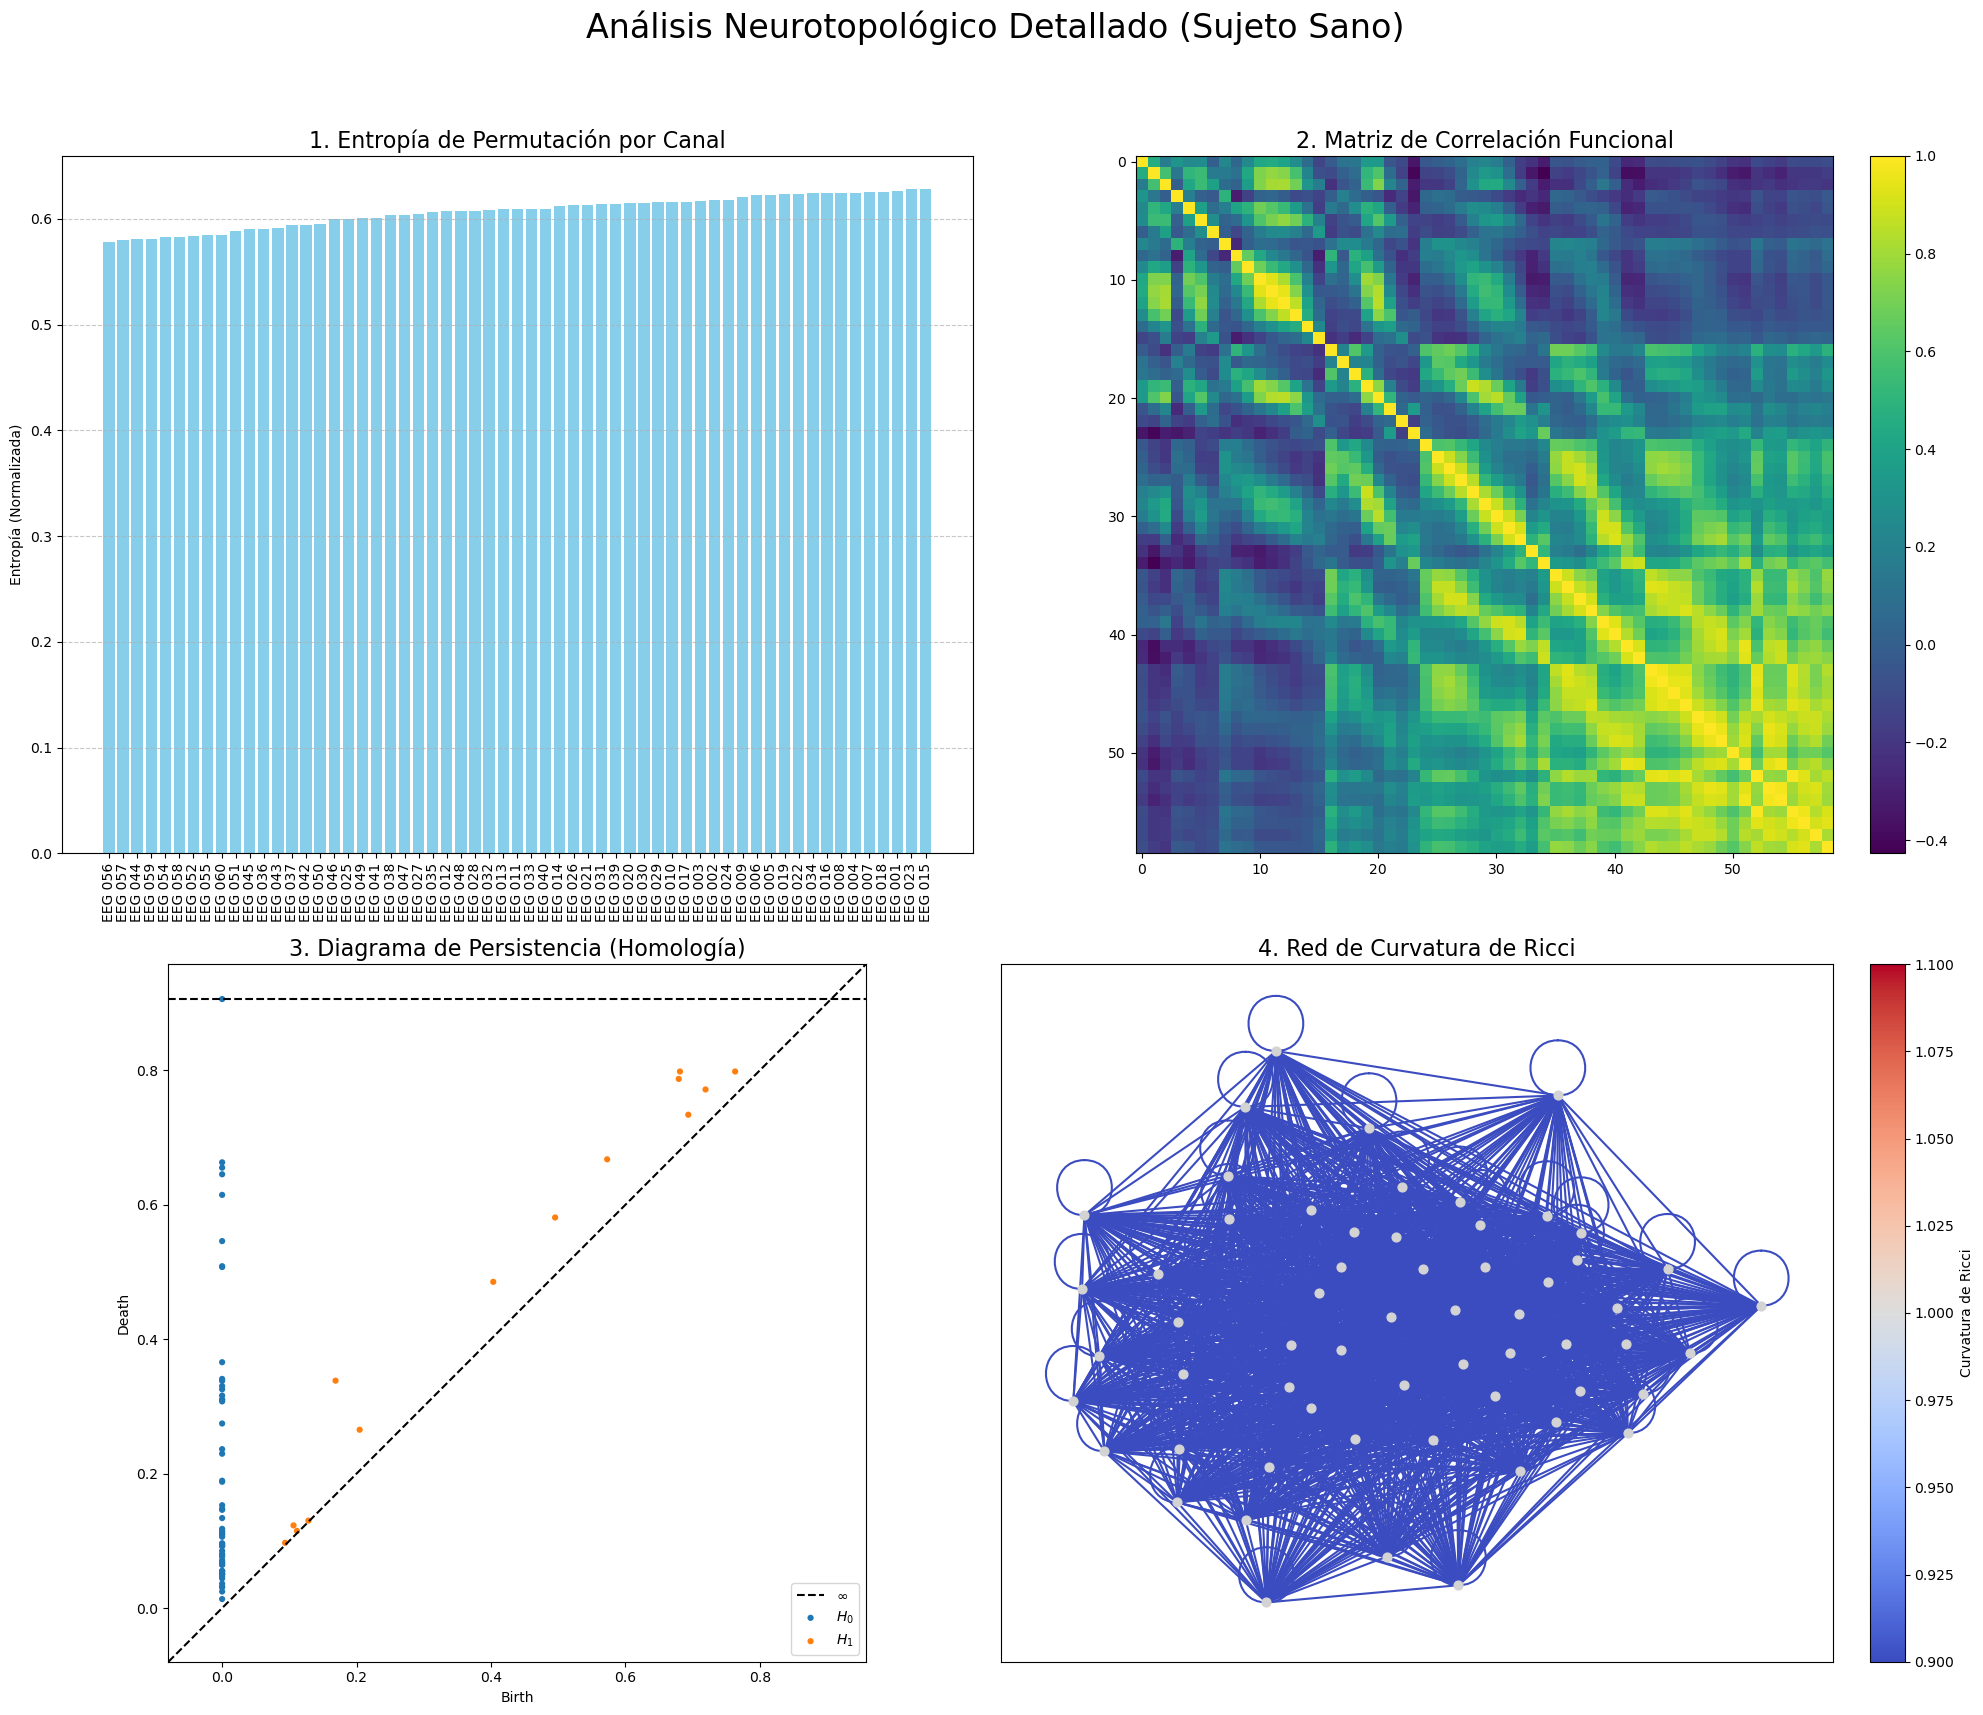


¡Éxito! Gráficos generados.


In [14]:
# --- IMPORTACIÓN DE BIBLIOTECAS PARA EL ANÁLISIS ---
import numpy as np
import matplotlib.pyplot as plt
import antropy as ant
import mne
from mne.preprocessing import ICA
import networkx as nx
from scipy.stats import wasserstein_distance
import ripser
import persim
import os

# --- Nos aseguramos de que las variables existen antes de graficar ---
# (Este código es de tus celdas anteriores, para que puedas ejecutar esta celda de forma independiente)
print("Calculando las métricas para los gráficos detallados...")

# A. ENTROPÍA
datos_eeg_entropia = raw_cleaned_filtered.get_data(units='V')
nombres_canales = raw_cleaned.ch_names
entropias = [ant.perm_entropy(canal, normalize=True) for canal in datos_eeg_entropia]

# B. MATRIZ, HOMOLOGÍA Y CURVATURA
datos_segmento = raw_cleaned_filtered.copy().crop(tmin=60, tmax=120).get_data(units='V')
matriz_correlacion = np.nan_to_num(np.corrcoef(datos_segmento.T, rowvar=False))
matriz_distancia = 1 - np.abs(matriz_correlacion)
diagramas_homologia = ripser.ripser(matriz_distancia, maxdim=1, distance_matrix=True)['dgms']

def calcular_curvatura(G):
    for u, v in G.edges():
        d_u, d_v = G.degree(u), G.degree(v)
        if d_u < 2 or d_v < 2: continue
        p_u, p_v = np.ones(d_u)/d_u, np.ones(d_v)/d_u
        dist = wasserstein_distance(np.arange(d_u), np.arange(d_v), p_u, p_v)
        G[u][v]['ricciCurvature'] = 1 - dist
    return G
G = nx.from_numpy_array(np.abs(matriz_correlacion))
G_con_curvatura = calcular_curvatura(G.copy())
curvaturas = [d.get('ricciCurvature', 0.0) for u, v, d in G_con_curvatura.edges(data=True)]

print("Métricas calculadas. Generando el panel de gráficos...")

# --- PANEL DE VISUALIZACIÓN DETALLADA ---
fig, axs = plt.subplots(2, 2, figsize=(20, 18))
fig.suptitle('Análisis Neurotopológico Detallado (Sujeto Sano)', fontsize=24)

# 1. Gráfico de Barras de la Entropía
sorted_indices_entropy = np.argsort(entropias)
sorted_entropias = np.array(entropias)[sorted_indices_entropy]
sorted_canales = np.array(nombres_canales)[sorted_indices_entropy]
axs[0, 0].bar(sorted_canales, sorted_entropias, color='skyblue')
axs[0, 0].set_title('1. Entropía de Permutación por Canal', fontsize=16)
axs[0, 0].set_ylabel('Entropía (Normalizada)')
axs[0, 0].tick_params(axis='x', rotation=90)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Matriz de Correlación
im = axs[0, 1].imshow(matriz_correlacion, cmap='viridis', interpolation='nearest')
axs[0, 1].set_title('2. Matriz de Correlación Funcional', fontsize=16)
fig.colorbar(im, ax=axs[0, 1], fraction=0.046, pad=0.04)

# 3. Diagrama de Homología
persim.plot_diagrams(diagramas_homologia, ax=axs[1, 0], show=False)
axs[1, 0].set_title('3. Diagrama de Persistencia (Homología)', fontsize=16)

# 4. Red de Curvatura de Ricci
pos = nx.spring_layout(G_con_curvatura, seed=42)
edges = nx.draw_networkx_edges(G_con_curvatura, pos, ax=axs[1, 1], edge_color=curvaturas, edge_cmap=plt.cm.coolwarm, width=1.5)
nodes = nx.draw_networkx_nodes(G_con_curvatura, pos, ax=axs[1, 1], node_color='lightgray', node_size=40)
cbar_curv = fig.colorbar(edges, ax=axs[1, 1], fraction=0.046, pad=0.04)
cbar_curv.set_label('Curvatura de Ricci')
axs[1, 1].set_title('4. Red de Curvatura de Ricci', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Guardamos la imagen en tu computadora
plt.savefig("analisis_detallado_sano.png")
plt.show() # Mostramos la imagen en el cuaderno

print("\n¡Éxito! Gráficos generados.")

In [16]:
import mne

# Este comando verifica la existencia del dataset de muestra 
# y lo descarga si es necesario, mostrando el progreso.
try:
    mne.datasets.sample.data_path(verbose=True)
    print("\n¡Éxito! El conjunto de datos del sujeto sano ha sido verificado y está listo.")
    print("Por favor, intenta ejecutar el código de la simulación de nuevo.")
except Exception as e:
    print(f"\nOcurrió un error durante la descarga o verificación: {e}")
    print("Asegúrate de tener una conexión a internet estable e inténtalo de nuevo.")


¡Éxito! El conjunto de datos del sujeto sano ha sido verificado y está listo.
Por favor, intenta ejecutar el código de la simulación de nuevo.


In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
import antropy as ant
import imageio
from mne.datasets.sample import data_path as sample_data_path

# --- PASO 1: Carga y Limpieza de Datos del SUJETO SANO ---
print("\n--- PASO 1: Cargando y limpiando datos del SUJETO SANO ---")
try:
    print("Cargando datos del sujeto sano...")
    sample_data_folder = sample_data_path(verbose=False)
    sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_raw.fif')
    raw_sano = mne.io.read_raw_fif(sample_data_raw_file, preload=True, verbose=False)
    raw_sano.pick_types(eeg=True)
    
    print("Limpiando datos con ICA...")
    raw_sano_filtered = raw_sano.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)
    ica_sano = ICA(n_components=30, max_iter='auto', random_state=97)
    ica_sano.fit(raw_sano_filtered, verbose=False)
    ica_sano.exclude = [0, 1, 2] # Tu decisión basada en el análisis previo
    raw_cleaned_sano = ica_sano.apply(raw_sano.copy(), verbose=False)
    print("Datos del sujeto sano listos.")
except Exception as e:
    print(f"ERROR con los datos del sujeto sano: {e}")
    raise e

# --- PASO 2: Configuración de la Simulación ---
print("\n--- PASO 2: Configurando la simulación ---")
NOMBRE_VIDEO = 'simulacion_sujeto_sano.mp4'
CARPETA_FOTOGRAMAS = 'fotogramas_sano'
if not os.path.exists(CARPETA_FOTOGRAMAS):
    os.makedirs(CARPETA_FOTOGRAMAS)

# Parámetros de la ventana de tiempo y video
inicio_simulacion = 60.0   # Empezar en el segundo 60 de la grabación
fin_simulacion = 180.0     # Terminar en el segundo 180 (video de 2 minutos de datos)
duracion_fotograma = 2.0   # Ventana para calcular la entropía (en segundos)
paso_tiempo = 0.5          # Cuánto avanza la ventana en cada fotograma
FPS_VIDEO = 5              # Fotogramas por segundo del video final

# --- PASO 3: Generación de Fotogramas ---
print("\n--- PASO 3: Generando fotogramas (esto puede tardar)... ---")
lista_fotogramas = []
tiempos_simulacion = np.arange(inicio_simulacion, fin_simulacion, paso_tiempo)
n_fotogramas = len(tiempos_simulacion)
vmin, vmax = 0.5, 1.0 

for i, t_start in enumerate(tiempos_simulacion):
    t_end = t_start + duracion_fotograma
    
    # Obtener datos y calcular entropía
    datos_ventana = raw_cleaned_sano.copy().crop(tmin=t_start, tmax=t_end).get_data(units='uV')
    if datos_ventana.shape[1] == 0: # Si la ventana no tiene datos, saltar
        continue
    
    entropias = [ant.perm_entropy(ch, normalize=True) for ch in datos_ventana]

    # --- Creación del Gráfico ---
    fig, ax = plt.subplots(figsize=(8, 8))
    titulo = f'Entropía Sujeto Sano | Tiempo: {t_start:.2f} s'
    
    im, _ = mne.viz.plot_topomap(entropias, raw_cleaned_sano.info, axes=ax, show=False, vlim=(vmin, vmax), cmap='viridis')
    
    ax.set_title(titulo, fontsize=16)
    
    # Añadir barra de color
    cax = fig.add_axes([0.92, 0.25, 0.04, 0.5])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Entropía de Permutación')
    
    # Guardar fotograma
    filepath = os.path.join(CARPETA_FOTOGRAMAS, f'frame_{i:04d}.png')
    plt.savefig(filepath)
    plt.close(fig)
    lista_fotogramas.append(filepath)
    
    if (i + 1) % 10 == 0:
      print(f"Fotograma {i+1}/{n_fotogramas} generado...")

# --- PASO 4: Ensamblado del Video ---
print("\n--- PASO 4: Ensamblando el video final ---")
try:
    with imageio.get_writer(NOMBRE_VIDEO, fps=FPS_VIDEO) as writer:
        for filename in lista_fotogramas:
            image = imageio.imread(filename)
            writer.append_data(image)
    print(f"\n¡SIMULACIÓN COMPLETADA! El video se ha guardado como '{NOMBRE_VIDEO}'.")
except Exception as e:
    print(f"\nERROR al ensamblar el video: {e}")


--- PASO 1: Cargando y limpiando datos del SUJETO SANO ---
Cargando datos del sujeto sano...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Limpiando datos con ICA...
Datos del sujeto sano listos.

--- PASO 2: Configurando la simulación ---

--- PASO 3: Generando fotogramas (esto puede tardar)... ---
Fotograma 10/240 generado...
Fotograma 20/240 generado...
Fotograma 30/240 generado...
Fotograma 40/240 generado...
Fotograma 50/240 generado...
Fotograma 60/240 generado...
Fotograma 70/240 generado...
Fotograma 80/240 generado...
Fotograma 90/240 generado...
Fotograma 100/240 generado...
Fotograma 110/240 generado...
Fotograma 120/240 generado...
Fotograma 130/240 generado...
Fotograma 140/240 generado...
Fotograma 150/240 generado...
Fotograma 160/240 generado...
Fotograma 170/240 generado...
Fotograma 180/240 generado...
Fotograma 190/240 generado...
Fotograma 200/240 generado...
Fotograma 210/240 generado...
Fotograma 220/240 generado...
Fotograma 230/24

C:\Users\artur\AppData\Local\Temp\ipykernel_31832\2903552354.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



¡SIMULACIÓN COMPLETADA! El video se ha guardado como 'simulacion_sujeto_sano.mp4'.
